Список былых империй:
https://en.wikipedia.org/wiki/Category:Former_empires

Требуется написать два скрипта на языке Python. Первый обрабатывает указанную html-страницу и записывает список ссылок на страницы с названием в файл. В список попадают ссылки только на те страницы, на которых в информационной плашке есть поля

«Proceded by» или «Succeeded by» (например, Roman Empire). Второй скрипт выводит названия империй и просит пользователя выбрать одну из них. После этого по заданной странице строится ориентированный граф: вершинами являются страны, причём страна A и страна Б соединяются ребром, если у страны А в информационной плашке страна Б указана в списке «Succeeded by» или у страны Б страна А числится в списке «Proceeded by». Потом процедура рекурсивно повторяется для всех стран, указанных в этих списках.

In [61]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt


def get_links_from_wikipedia_category(url):
    # Отправляем GET-запрос для загрузки HTML-страницы
    response = requests.get(url)
    print(response.status_code)
    
    # Проверяем успешность запроса
    if response.status_code == 200:
        # Используем BeautifulSoup для парсинга HTML
        soup = BeautifulSoup(response.content, 'html.parser')
        start_parsing = 0
        links_dict = {}
        end_string = '<div class="printfooter"'
        for element in soup.find_all():
            #print('--- ', str(link)[0:200])
            if  '<h3>A</h3>' == str(element):
                start_parsing = 1
            if end_string == str(element)[0:len(end_string)]:
                start_parsing = 0
            if start_parsing:
                if (element.get('href') != None):
                    url = "https://en.wikipedia.org" + element.get('href')
                    response = requests.get(url)
                    if response.status_code == 200:
                        # Используем BeautifulSoup для парсинга HTML
                        soup1 = BeautifulSoup(response.content, 'html.parser')
                        if soup1.findAll(text="Preceded by") or soup1.findAll(text="Succeeded by"):
                            links_dict[element.text] = element.get('href')
                        #    print('---------', element.text, '\twas preceded or succeeded')
                        #else: 
                        #    print(element.text, '\twas NOT pr. or suc.')
                    else: 
                        links_dict[element.text] = 'unk'
        return links_dict
    else:
        # Если запрос не был успешным, выводим сообщение об ошибке
        print("Ошибка при загрузке страницы:", response.status_code)
        return []

# URL страницы с категорией на Wikipedia
url = "https://en.wikipedia.org/wiki/Category:Former_empires"
# Получаем список ссылок на странице
links = get_links_from_wikipedia_category(url)
# Выводим список ссылок
for link in links:
    print(link, links[link])


200
Abbasid Caliphate /wiki/Abbasid_Caliphate
Achaemenid Empire /wiki/Achaemenid_Empire
Ajuran Sultanate /wiki/Ajuran_Sultanate
Akkadian Empire /wiki/Akkadian_Empire
Ancient Carthage /wiki/Ancient_Carthage
Kingdom of Armenia (antiquity) /wiki/Kingdom_of_Armenia_(antiquity)
Ashanti Empire /wiki/Ashanti_Empire
Assyria /wiki/Assyria
Austria-Hungary /wiki/Austria-Hungary
Austrian Empire /wiki/Austrian_Empire
Babylonia /wiki/Babylonia
Bamana Empire /wiki/Bamana_Empire
Bengal Sultanate /wiki/Bengal_Sultanate
Byzantine Empire /wiki/Byzantine_Empire
Carolingian Empire /wiki/Carolingian_Empire
Western Chalukya Empire /wiki/Western_Chalukya_Empire
Empire of China (1915–1916) /wiki/Empire_of_China_(1915%E2%80%931916)
Crown of Aragon /wiki/Crown_of_Aragon
Dzungar Khanate /wiki/Dzungar_Khanate
Eastern Turkic Khaganate /wiki/Eastern_Turkic_Khaganate
Empire of Kitara /wiki/Empire_of_Kitara
Ethiopian Empire /wiki/Ethiopian_Empire
First Bulgarian Empire /wiki/First_Bulgarian_Empire
First Empire of Hait

In [67]:
import requests
from bs4 import BeautifulSoup

def get_preceded_by_and_succeeded_by_countries(url):
    # URL страницы Википедии о Римской империи
    
    # Загрузка HTML-кода страницы
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    if not (soup.findAll(text="Preceded by") or soup.findAll(text="Succeeded by")):
        return [], [], {}
    # Находим таблицу, содержащую информацию о Preceded by и Succeeded by
    table = soup.find("table").find("table")
    if table == None:
        table = soup.find("table")
        if table == None:
            print(url)
            return [], [], {}
    countries_dict = {}
    # Инициализация списка для хранения стран
    countries_prec = []
    countries_succ = []
    get_prec = 0
    get_succ = 0
    start_recording = 0
    # Поиск строк таблицы, содержащих информацию о Preceded by и Succeeded by
    for row in table.find_all("td"): 
        if "Preceded by" in row.text:
            get_prec = 1
        if "Succeeded by" in row.text:
            get_succ = 1
        if row.find_all("tbody"):
            link = row.find_all("a")
            for s in link:
                #print(s)
                countries_dict[s.get('title')] = "https://en.wikipedia.org" + s.get('href')
                if get_prec == 1:
                    countries_prec.append(s.get('title'))
                else:
                    countries_succ.append(s.get('title'))
            if get_prec == 1:
                get_prec = 2
    
    return countries_prec, countries_succ, countries_dict


def make_TGF_file(start_empire ='Eastern Xia', url = "https://en.wikipedia.org/wiki/Eastern_Xia"):
    dict_countries = {0: start_empire}
    dict_connections = []  # '1 2' means 2nd country is preceded by 1st
    country_check = [1]    # 1 if the n-th country is checked
    num_countries = 1      # total number of countries
    url_dict = {}          # 'country_name': 'country_url'

    c1, c2, url_dict = get_preceded_by_and_succeeded_by_countries(url)
    for c in c1:
        tmp_str = str(num_countries) + ' 0\n'
        if tmp_str not in dict_connections:
            dict_connections.append(tmp_str)
        if c not in dict_countries.values():
            dict_countries[num_countries] = c
            country_check.append(0)
            num_countries += 1
    for c in c2:
        tmp_str = '0 ' + str(num_countries)+ '\n'
        if tmp_str not in dict_connections:
            dict_connections.append(tmp_str)
        if c not in dict_countries.values():
            dict_countries[num_countries] = c
            country_check.append(0)
            num_countries += 1

    while 0 in country_check:
        i = 0 
        while country_check[i]:
            i+=1
        cur_country = dict_countries[i]
        cur_url = url_dict[cur_country]
        c1, c2, dict_new = get_preceded_by_and_succeeded_by_countries(cur_url)
        url_dict = {**url_dict, **dict_new}
        for c in c1:
            tmp_str = str(num_countries) + ' ' + str(i) + '\n'
            if tmp_str not in dict_connections:
                dict_connections.append(tmp_str)
            if c not in dict_countries.values():
                dict_countries[num_countries] = c
                country_check.append(0)
                num_countries += 1
        for c in c2:
            tmp_str = str(i) + ' ' + str(num_countries) + '\n'
            if tmp_str not in dict_connections:
                dict_connections.append(tmp_str)
            if c not in dict_countries.values():
                dict_countries[num_countries] = c
                country_check.append(0)
                num_countries += 1
        country_check[i] = 1
        if (i == 10):
            break
    my_str = ''
    for d in dict_countries:
        my_str += str(d) + ' ' + dict_countries[d] + '\n'
    #print(my_str)
    #print(' '.join(dict_connections))
    with open("TGF_empires", "w") as text_file:
        text_file.write(my_str + ' '.join(dict_connections))
    return dict_countries, dict_connections

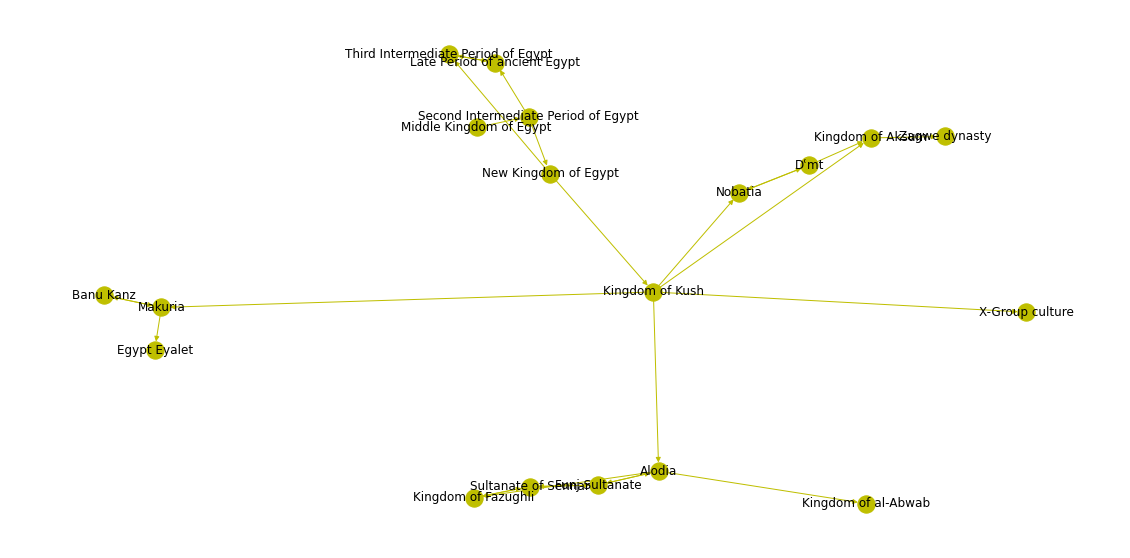

In [70]:
dict_countries, dict_connections = make_TGF_file(start_empire ='Kingdom of Kush', url = "https://en.wikipedia.org/wiki/Kingdom_of_Kush")
f, ax = plt.subplots(figsize=(20, 10))
G=nx.DiGraph(directed=True)
for d in dict_countries:
    G.add_node(dict_countries[d])
for con in dict_connections:
    con = con.replace('\n', '').split(' ')
    G.add_edge(dict_countries[int(con[0])], dict_countries[int(con[1])] )
    #my_str += str(d) + ' ' + dict_countries[d] + '\n'

nx.draw(G, with_labels = True, node_color = 'y', edge_color = 'y')